In [2]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import cv2


from utils import *
from models.CtRNet import CtRNet
from models.heatmap import compute_gaussian_heatmap, heatmap_to_keypoints



# Panda

In [3]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.trained_on_multi_gpus = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/panda/panda-3cam_azure/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")

args.robot_name = 'Panda' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.height = 480
args.width = 640
args.fx, args.fy, args.px, args.py = 399.6578776041667, 399.4959309895833, 319.8955891927083, 244.0602823893229
args.scale = 0.5 # scale the input image size to (320,240)

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [4]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/panda/panda-3cam_azure/net.pth
Camera intrinsics: [[199.8289388    0.         159.9477946 ]
 [  0.         199.74796549 122.03014119]
 [  0.           0.           1.        ]]
Robot model: Panda


In [5]:
cv_img = cv2.imread(os.path.join(args.base_dir,"images/panda.jpg"))
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()

joint_angles = np.array([ 0.0200, -0.9641, -0.0662, -2.7979, -0.0469,  1.9289,  0.9137])

cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[[ 0.8575,  0.5139, -0.0044, -0.1976],
         [ 0.0952, -0.1674, -0.9811,  0.3963],
         [-0.5050,  0.8412, -0.1925,  1.0495],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


In [6]:
points_2d

tensor([[[121.7508, 197.2096],
         [121.7311, 138.3067],
         [ 87.9822,  96.0673],
         [ 75.1244,  87.6170],
         [159.0641,  84.9116],
         [162.9904,  88.9614],
         [159.6268, 117.1111]]], device='cuda:0', grad_fn=<MulBackward0>)

In [21]:
resnet_out = CtRNet.keypoint_seg_predictor.module.backbone(image[None])['out']
heatmap = CtRNet.keypoint_seg_predictor.module.read_out(resnet_out) # (B, k, H//4, W//4)
# upsample the heatmap to the original image size
heatmap = torch.nn.functional.interpolate(heatmap, (args.height, args.width), mode='bilinear', align_corners=False)
# get the keypoints
keypoints = heatmap_to_keypoints(heatmap)

#keypoints = CtRNet.keypoint_seg_predictor.module.spatialsoftargmax(heatmap)
#offset = torch.tensor([-1,-1], device = resnet_out.device)
#scale = torch.tensor([args.width // 2, args.height // 2], device = resnet_out.device)
#keypoints = keypoints - offset
#eypoints = keypoints * scale


In [22]:
heatmap.shape

torch.Size([1, 7, 240, 320])

In [23]:
keypoints

tensor([[[-0.2195,  0.6146],
         [-0.2358,  0.1492],
         [-0.3984, -0.1795],
         [-0.5068, -0.2637],
         [ 0.0029, -0.2845],
         [-0.0899, -0.1503],
         [ 0.0137, -0.0098]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [24]:
heatmap_to_keypoints(heatmap)

tensor([[[122.0000, 197.0000],
         [126.0000, 137.0000],
         [ 85.0000, 102.0000],
         [ 78.0000,  90.0000],
         [158.0000,  85.0000],
         [  0.5000,   0.5000],
         [157.0000, 113.0000]]], device='cuda:0', grad_fn=<StackBackward0>)

In [13]:
heatmap.shape

torch.Size([1, 7, 60, 80])

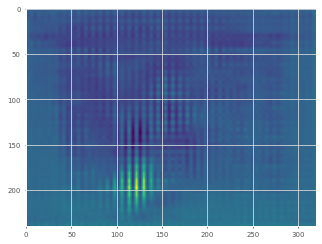

In [20]:
plt.imshow(heatmap.squeeze()[0].detach().cpu().numpy())

In [ ]:
input_shape = img.shape[-2:]

resnet_out = self.backbone(img)['out']  # (B, 2048, H//8, W//8)

# keypoint prediction branch
heatmap = self.read_out(resnet_out) # (B, k, H//4, W//4)
keypoints = self.spatialsoftargmax(heatmap)
# mapping back to original resolution from [-1,1]
offset = torch.tensor([self.lim[0], self.lim[2]], device = resnet_out.device)
scale = torch.tensor([self.args.width // 2, self.args.height // 2], device = resnet_out.device)
keypoints = keypoints - offset
keypoints = keypoints * scale

In [88]:
keypoints = torch.tensor([[50,50],[100,100],[150,150],[200,200],[300,200]],dtype=torch.float32, requires_grad=True)[None]

In [89]:
heatmap = compute_gaussian_heatmap(keypoints, torch.Size([240,320]),std=1.5)

In [90]:
heatmap.shape

torch.Size([1, 5, 240, 320])

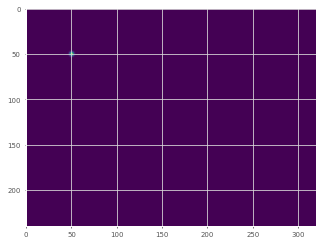

In [91]:
plt.imshow(heatmap.squeeze()[0].detach().cpu().numpy())

In [92]:
keypoints = CtRNet.keypoint_seg_predictor.module.spatialsoftargmax(heatmap)
keypoints = keypoints - offset.cpu()
keypoints = keypoints * scale.cpu()
keypoints

tensor([[[159.9734, 119.9831],
         [159.9855, 119.9953],
         [159.9977, 120.0074],
         [160.0099, 120.0196],
         [160.0342, 120.0196]]], grad_fn=<MulBackward0>)

In [93]:
heatmap_to_keypoints(heatmap)

tensor([[[ 50.,  50.],
         [100., 100.],
         [150., 150.],
         [200., 200.],
         [300., 200.]]], grad_fn=<StackBackward0>)